In [0]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torch import autograd

from tqdm import tqdm
import sys, random, glob
from itertools import chain
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from inception_score import get_inception_score
from fid import get_fid_score

In [0]:
SEED = 1234
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
# batches of 64 images of size 32x32x3

BATCH_SIZE = 64
NUM_WORKERS = 4
LATENT_DIM = 100
IN_CHANNELS = 3
OUT_CHANNELS = 3

IMG_SIZE = 32

transform = transforms.Compose([transforms.Resize(IMG_SIZE),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = datasets.CIFAR10('datasets/CIFAR10',
                               transform=transform)

dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         num_workers=NUM_WORKERS)

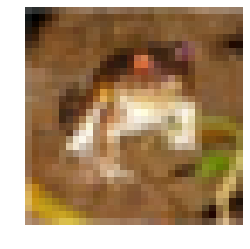

In [0]:
img, _ = dataset[0] # image data should either be floats in [0, 1] or integers in [0, 255]
assert img.shape == (IN_CHANNELS, IMG_SIZE, IMG_SIZE)
assert isinstance(img, torch.Tensor)

img = (img.permute(1, 2, 0) + 1)/2 # HWC and denorm

ax = plt.gca()
ax.imshow(img)
ax.axis('off')
plt.show()

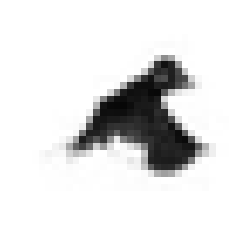

In [0]:
imgs, _ = next(iter(dataloader))

assert imgs.shape == (BATCH_SIZE, IN_CHANNELS, IMG_SIZE, IMG_SIZE)
assert isinstance(imgs, torch.Tensor)

img = (imgs[0].permute(1, 2, 0) + 1)/2 # HWC and denorm

ax = plt.gca()
ax.imshow(img)
ax.axis('off')
plt.show()

In [0]:
# W --> (W - 1)S + K - 2P
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_ch):
        super().__init__()

        self.model = nn.Sequential(
            # input is z: 100 x (1 x 1)
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            # state size: 512 x (4 x 4)
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # state size: 256 x (8 x 8)
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # state size: 128 x (16 x 16)
            nn.ConvTranspose2d(128, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # state size: 64 x (16 x 16)
            nn.ConvTranspose2d(64, output_ch, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: och x (32 x 32)
        )
        # input order: NCHW (batch, channels, height, width)
        
    def forward(self, z):
        Gz = self.model(z)
        return Gz

In [0]:
# W --> [(W - K + 2P)/S + 1], no BN/Sigmoid in Critic for WGAN-GP
class Encoder(nn.Module):
    def __init__(self, input_ch, latent_dim):
        super().__init__()

        self.model = nn.Sequential(
            # input size: ich x (32 x 32)
            nn.Conv2d(input_ch, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: 64 x (16 x 16)
            nn.Conv2d(64, 128, 3, 1, 1, bias=False),
#             nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: 128 x (16 x 16)
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: 256 x (8 x 8)
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: 512 x (4 x 4)
            nn.Conv2d(512, latent_dim, 4, 1, 0, bias=False), # changed (512, 1, ..) to (512, 100, ..), removed sigmoid, removed flattening from forward
            #nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [0]:
# custom weights initialization for G, D
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

        
netAE = nn.Sequential(Encoder(IN_CHANNELS, LATENT_DIM),
                      Decoder(LATENT_DIM, OUT_CHANNELS)).to(device)
netAE.apply(init_weights)
netAE

Sequential(
  (0): Encoder(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace)
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace)
      (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (5): LeakyReLU(negative_slope=0.2, inplace)
      (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): LeakyReLU(negative_slope=0.2, inplace)
      (8): Conv2d(512, 100, kernel_size=(4, 4), stride=(1, 1), bias=False)
    )
  )
  (1): Decoder(
    (model): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), str

In [0]:
opt = optim.Adam(netAE.parameters(), lr=0.0001, betas=(0.5, 0.999))
criterion = torch.nn.MSELoss()

def denorm(x):
    out = (x + 1)/2
    return out.clamp(0, 1)

In [0]:
SAMPLES = 6
imgloader = torch.utils.data.DataLoader(dataset, batch_size=SAMPLES, shuffle=True)
imgs, _ = next(iter(imgloader))
imgs = imgs.to(device)

Epoch: 01/30 | Loss: 0.06023
Epoch: 02/30 | Loss: 0.03670


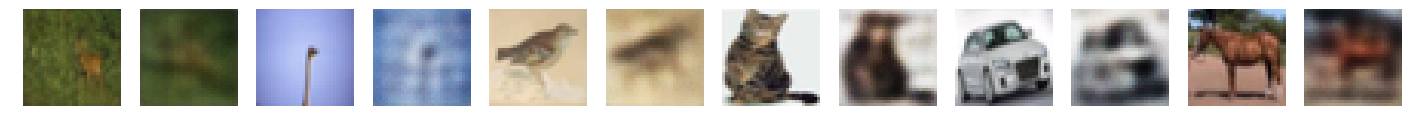

Epoch: 03/30 | Loss: 0.03119
Epoch: 04/30 | Loss: 0.02836


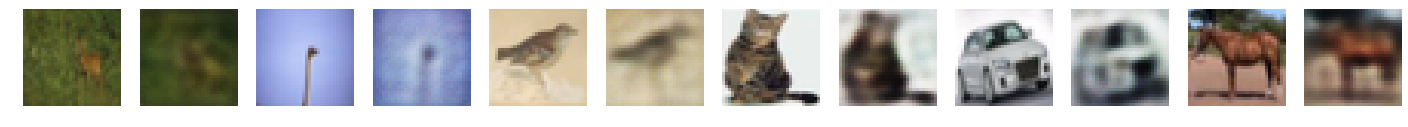

Epoch: 05/30 | Loss: 0.02674
Epoch: 06/30 | Loss: 0.02590


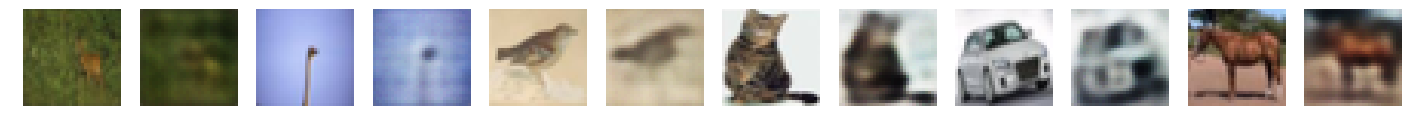

Epoch: 07/30 | Loss: 0.02543
Epoch: 08/30 | Loss: 0.02481


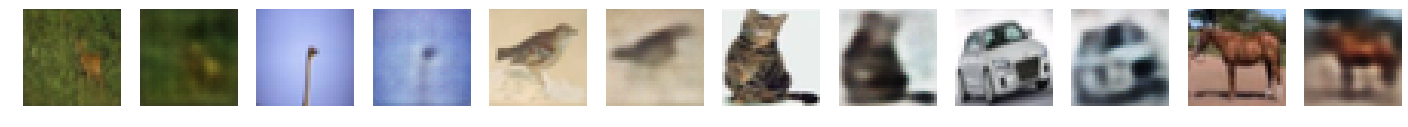

Epoch: 09/30 | Loss: 0.02442
Epoch: 10/30 | Loss: 0.02404


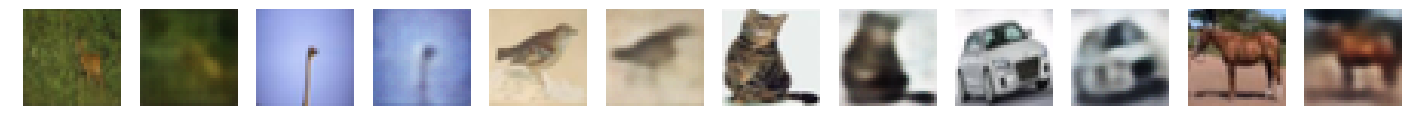

Epoch: 11/30 | Loss: 0.02376
Epoch: 12/30 | Loss: 0.02350


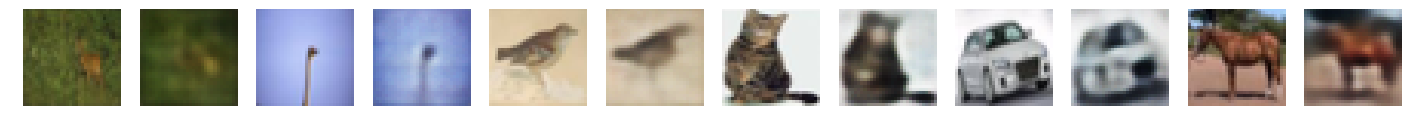

Epoch: 13/30 | Loss: 0.02317
Epoch: 14/30 | Loss: 0.02290


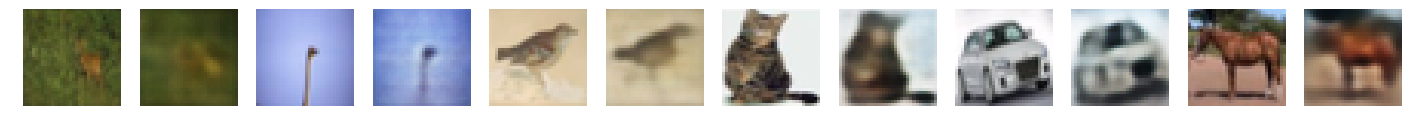

Epoch: 15/30 | Loss: 0.02274
Epoch: 16/30 | Loss: 0.02254


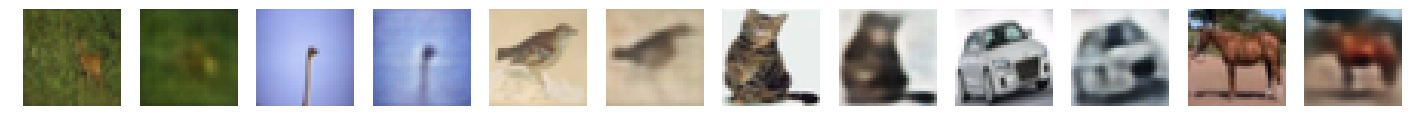

Epoch: 17/30 | Loss: 0.02231
Epoch: 18/30 | Loss: 0.02214


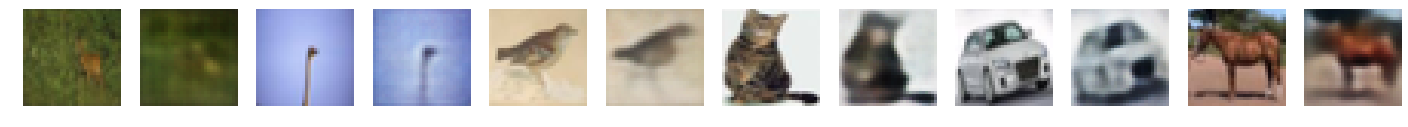

Epoch: 19/30 | Loss: 0.02190
Epoch: 20/30 | Loss: 0.02183


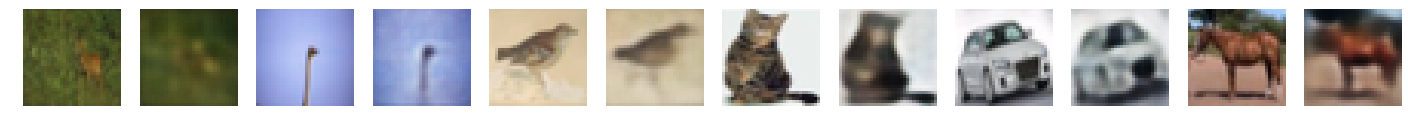

Epoch: 21/30 | Loss: 0.02159
Epoch: 22/30 | Loss: 0.02149


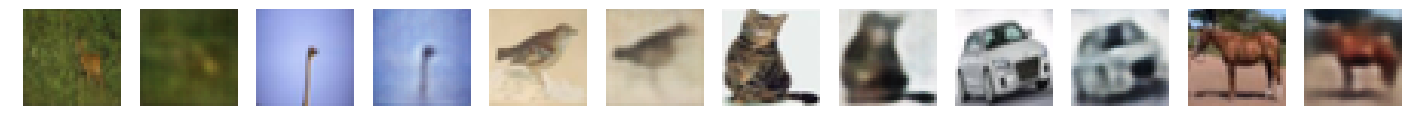

Epoch: 23/30 | Loss: 0.02130
Epoch: 24/30 | Loss: 0.02114


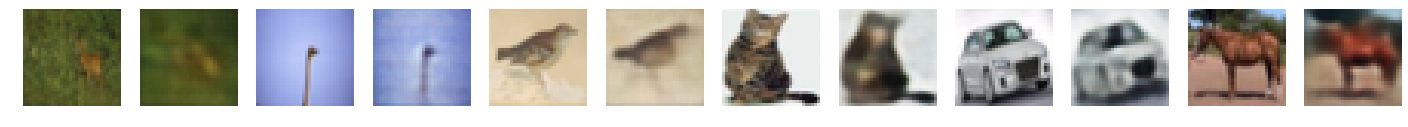

Epoch: 25/30 | Loss: 0.02096
Epoch: 26/30 | Loss: 0.02082


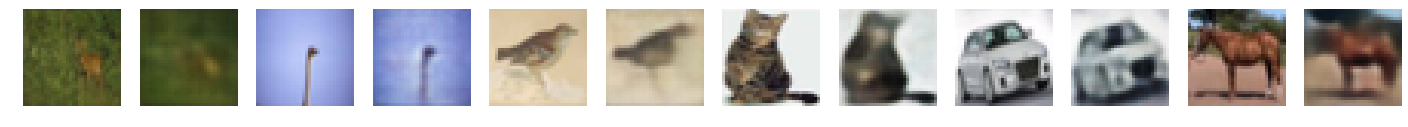

Epoch: 27/30 | Loss: 0.02068
Epoch: 28/30 | Loss: 0.02053


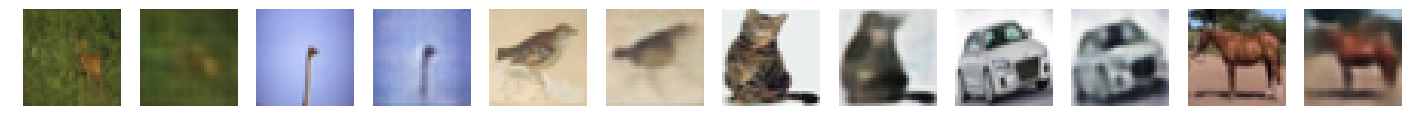

Epoch: 29/30 | Loss: 0.02039
Epoch: 30/30 | Loss: 0.02025


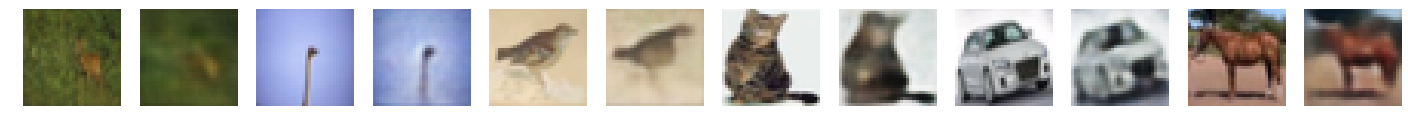

In [0]:
#=========================AUTOENCODER=========================#
EPOCHS = 30
SAVE_EVERY = 2
losses = []

for e in range(1, EPOCHS + 1):
    losses.append(0)
    
    #--------------------Training--------------------#
    for x, _ in dataloader:
        x = x.to(device)
        
        fx = netAE(x)
        loss = criterion(fx, x); losses[-1] += loss.item()
        opt.zero_grad()    
        loss.backward()
        opt.step()
    
    #---------------------Logging---------------------#
    losses[-1] /= len(dataloader)
    
    print(f"Epoch: {e:02}/{EPOCHS} "
          f"| Loss: {losses[-1]:.5f}", file=sys.stderr)
    
    #-------------------Save & Plot-------------------#
    if e % SAVE_EVERY == 0:
        filepath = f'models/notebook37/netAE-{e:02}-{losses[-1]:.4f}.pt'
        torch.save(netAE.state_dict(), filepath)
        
        with torch.no_grad():
            gen_imgs = netAE(imgs)

        fig, ax = plt.subplots(figsize=(22, 20), nrows=1, ncols=2*SAMPLES)
        for i in range(2*SAMPLES):
            img = gen_imgs[(i - 1) // 2] if i%2 else imgs[i // 2]
            img = denorm(img.data.cpu().permute(1, 2, 0))
            ax[i].imshow(img)
            ax[i].axis('off')
        plt.show()

# training time: 1.2 min/epoch, 36 mins

In [0]:
ls = glob.glob('models/notebook37/netAE-30-*')
filename = ls[-1]; print(filename)

netAE.load_state_dict(torch.load(filename, map_location=device))

next(netAE.parameters()).device

models/notebook37/netAE-30-0.0203.pt


device(type='cuda', index=0)

In [0]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

    
layersG = list(netAE[1].model.children())
layersD = list(netAE[0].model.children())

netG = nn.Sequential(*layersG).to(device)
netD = nn.Sequential(*layersD[:-1],
                    nn.Conv2d(512, 1, 4, 1, 0, bias=False),
#                     nn.Sigmoid(), # not needed for WGAN
                    Flatten()).to(device)

In [0]:
netG # len(netG), netG[0] also work

Sequential(
  (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace)
  (9): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [0]:
netD

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace)
  (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (3): LeakyReLU(negative_slope=0.2, inplace)
  (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (5): LeakyReLU(negative_slope=0.2, inplace)
  (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): LeakyReLU(negative_slope=0.2, inplace)
  (8): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (9): Flatten()
)

In [0]:
for i, layer in enumerate(netG.children()):
    if i in (0, 3): # changed (0, 1) to (0, 3)
        continue
    else:
        layer.apply(init_weights)

for i, layer in enumerate(netD.children()):
    if i in (6,): # changed (8, 9) to (8,)
        continue
    else:
        layer.apply(init_weights)
        

In [0]:
optG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [0]:
EPOCHS = 65 # 65 * 50000 // 64 ~ 60k iterations
SAMPLES = 12
LAMBDA = 10
D_UPDS = 5

torch.manual_seed(SEED)
zf = torch.randn(SAMPLES, LATENT_DIM, 1, 1).to(device) # fixed noise for sampling

best_score = 0.0

lossesG = []
lossesD = []
scores = []
for e in range(1, EPOCHS + 1):
    lossesG.append(0)
    lossesD.append(0)
    
    for j, (x, _) in enumerate(dataloader, 1):
        x = x.to(device)
        z = torch.randn(x.shape[0], LATENT_DIM, 1, 1).to(device)
        Gz = netG(z)

        if j % (D_UPDS + 1):
            #----------------Train discriminator: maximize log(D(x)) + log(1 - D(G(z)))----------------#
            # Calculate interpolation
            alpha = torch.rand(x.shape[0], 1, 1, 1).expand_as(x).to(device)
            interpolated = (1 - alpha) * x.data + alpha * Gz.data
            interpolated = Variable(interpolated, requires_grad=True).to(device)

            # Calculate probability of interpolated examples
            prob_interpolated = netD(interpolated)

            # Calculate gradients of probabilities with respect to examples
            gradients = autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                                   grad_outputs=torch.ones(prob_interpolated.size()).to(device),
                                   create_graph=True, retain_graph=True)[0]

            # Gradients have shape (batch_size, num_channels, img_width, img_height),
            # so flatten to easily take norm per example in batch
            gradients = gradients.view(x.shape[0], -1)

            # Derivatives of the gradient close to 0 can cause problems because of
            # the square root, so manually calculate norm and add epsilon
            gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=1) + 1e-12)

            gradient_penalty = LAMBDA * ((gradients_norm - 1)**2).mean()

            lossD = torch.mean(netD(Gz.detach()) - netD(x)) + gradient_penalty;
            lossesD[-1] += lossD.item()
            optD.zero_grad()
            lossD.backward()
            optD.step()

        else:
            #-------------------Train generator: maximize log(D(G(z)))-------------------#
            lossG = -torch.mean(netD(Gz)); lossesG[-1] += lossG.item()
            optG.zero_grad()
            lossG.backward()
            optG.step()

    #-------------------Save losses-------------------#
    lossesG[-1] /= len(dataloader) / (D_UPDS + 1)
    lossesD[-1] /= len(dataloader) * D_UPDS / (D_UPDS + 1)

    #-------------------Inception score-------------------#
    gen_imgs = []
    for i in range(50):
        z = torch.randn(1000, LATENT_DIM, 1, 1).to(device)
        with torch.no_grad():
            Gz = netG(z)
        imgs = Gz.data.cpu().permute(0, 2, 3, 1).numpy()
        imgs = imgs*127.5 + 127.5 # [-1, 1] --denorm--> [0, 1] --mul by 255--> [0, 255]
        gen_imgs.append(imgs)

    gen_imgs = list(np.concatenate(gen_imgs))
    score = get_inception_score(gen_imgs, batch_size=64, splits=10)
    scores.append(score)

    #------------------------Logging------------------------#
    print(f"Epoch: {e:02}/{EPOCHS} "
          f"| Gen. Loss: {lossesG[-1]:.5f} "
          f"| Disc. Loss: {lossesD[-1]:.5f} "
          f"| Incep. Score: {score[0]:.5f}", file=sys.stderr)

    if e == EPOCHS or best_score < score[0]:
        best_score = score[0]

        #---------------------Saving gen & disc---------------------#
        filepath = f'models/notebook37/netG-{e:02}-{lossesG[-1]:.3f}-{score[0]:.3f}.pt'
        torch.save(netG.state_dict(), filepath)
        filepath = f'models/notebook37/netD-{e:02}-{lossesD[-1]:.3f}.pt'
        torch.save(netD.state_dict(), filepath)

        #-------------------Sampling the generator-------------------#
        with torch.no_grad():
            Gz = netG(zf)

        fig, ax = plt.subplots(figsize=(22, 20), nrows=1, ncols=SAMPLES)
        for i in range(SAMPLES):
            img = denorm(Gz[i].data.cpu().permute(1, 2, 0))
            ax[i].imshow(img)
            ax[i].axis('off')
        plt.show()

# 5 min/epoch ~ 5.5 hrs

Epoch: 66/90 | Gen. Loss: 0.30876 | Disc. Loss: -1.26496 | Incep. Score: 5.89152


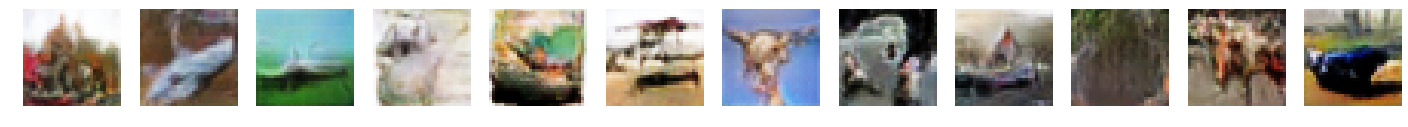

Epoch: 67/90 | Gen. Loss: 0.25689 | Disc. Loss: -1.24871 | Incep. Score: 5.86330
Epoch: 68/90 | Gen. Loss: 0.05405 | Disc. Loss: -1.24593 | Incep. Score: 6.05856


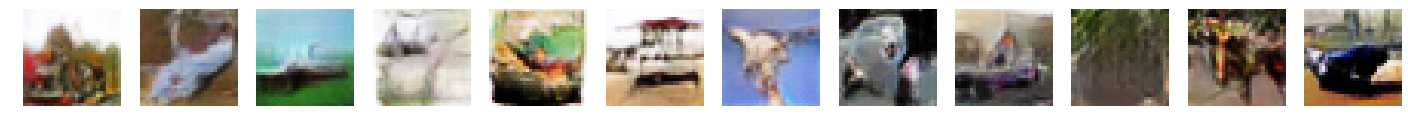

Epoch: 69/90 | Gen. Loss: 0.35931 | Disc. Loss: -1.25314 | Incep. Score: 6.00291
Epoch: 70/90 | Gen. Loss: 0.21905 | Disc. Loss: -1.22556 | Incep. Score: 5.88118
Epoch: 71/90 | Gen. Loss: 0.23709 | Disc. Loss: -1.25233 | Incep. Score: 5.95739
Epoch: 72/90 | Gen. Loss: 0.16609 | Disc. Loss: -1.23089 | Incep. Score: 5.83253
Epoch: 73/90 | Gen. Loss: 0.22015 | Disc. Loss: -1.22134 | Incep. Score: 5.93000
Epoch: 74/90 | Gen. Loss: 0.30092 | Disc. Loss: -1.23049 | Incep. Score: 5.87964
Epoch: 75/90 | Gen. Loss: 0.13647 | Disc. Loss: -1.22086 | Incep. Score: 6.02009
Epoch: 76/90 | Gen. Loss: 0.12760 | Disc. Loss: -1.25577 | Incep. Score: 6.05097
Epoch: 77/90 | Gen. Loss: 0.29817 | Disc. Loss: -1.21974 | Incep. Score: 5.87204
Epoch: 78/90 | Gen. Loss: 0.07372 | Disc. Loss: -1.21866 | Incep. Score: 6.03631
Epoch: 79/90 | Gen. Loss: 0.24587 | Disc. Loss: -1.23115 | Incep. Score: 6.04363
Epoch: 80/90 | Gen. Loss: 0.22196 | Disc. Loss: -1.24012 | Incep. Score: 6.08191


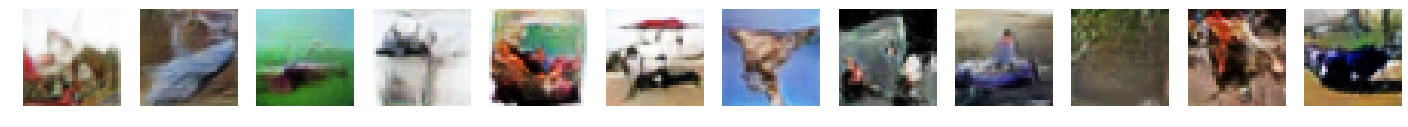

Epoch: 81/90 | Gen. Loss: 0.23041 | Disc. Loss: -1.20195 | Incep. Score: 6.01902
Epoch: 82/90 | Gen. Loss: 0.27089 | Disc. Loss: -1.22308 | Incep. Score: 6.05697
Epoch: 83/90 | Gen. Loss: 0.13644 | Disc. Loss: -1.19724 | Incep. Score: 5.91177
Epoch: 84/90 | Gen. Loss: 0.16930 | Disc. Loss: -1.21893 | Incep. Score: 6.13578


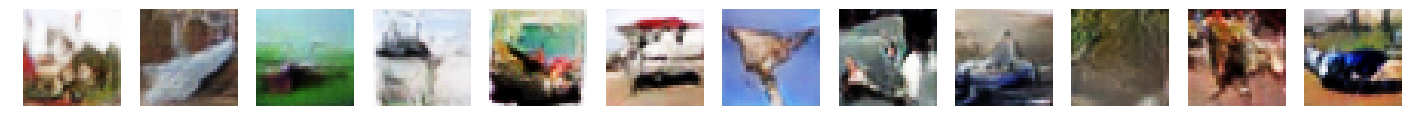

Epoch: 85/90 | Gen. Loss: 0.50175 | Disc. Loss: -1.22397 | Incep. Score: 6.00971
Epoch: 86/90 | Gen. Loss: -0.10545 | Disc. Loss: -1.22178 | Incep. Score: 6.03168
Epoch: 87/90 | Gen. Loss: 0.35844 | Disc. Loss: -1.22550 | Incep. Score: 6.22111


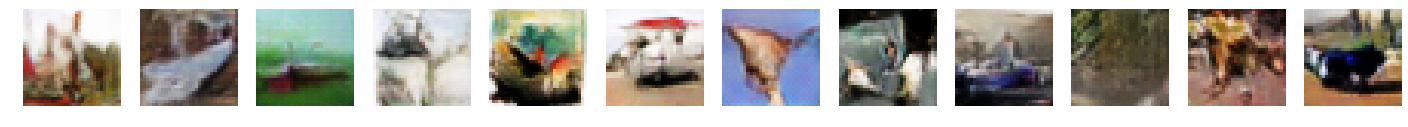

Epoch: 88/90 | Gen. Loss: 0.25631 | Disc. Loss: -1.20692 | Incep. Score: 5.96797
Epoch: 89/90 | Gen. Loss: 0.25825 | Disc. Loss: -1.20618 | Incep. Score: 5.99635
Epoch: 90/90 | Gen. Loss: 0.18546 | Disc. Loss: -1.20784 | Incep. Score: 6.01601


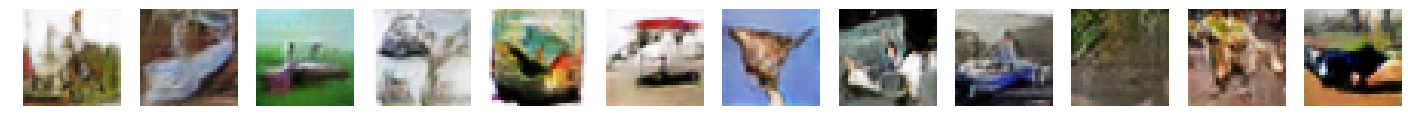

Epoch: 91/100 | Gen. Loss: 0.25286 | Disc. Loss: -1.20054 | Incep. Score: 6.05659


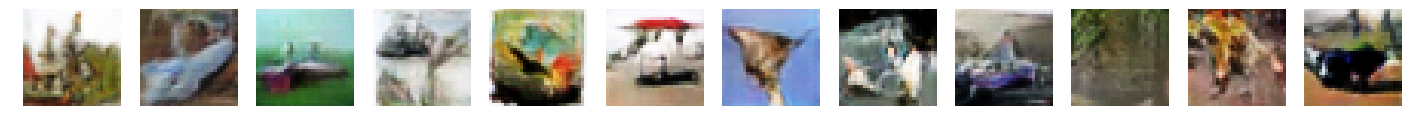

Epoch: 92/100 | Gen. Loss: 0.20876 | Disc. Loss: -1.19092 | Incep. Score: 6.07432


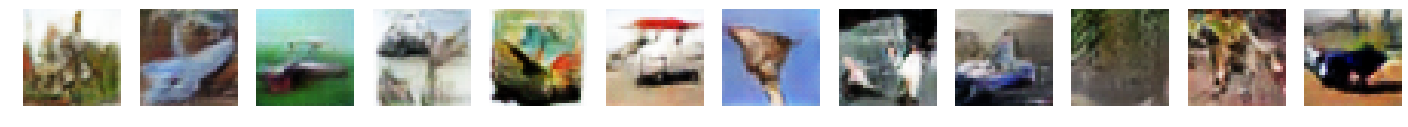

Epoch: 93/100 | Gen. Loss: 0.18249 | Disc. Loss: -1.20142 | Incep. Score: 6.03436
Epoch: 94/100 | Gen. Loss: 0.18289 | Disc. Loss: -1.20226 | Incep. Score: 6.05041
Epoch: 95/100 | Gen. Loss: 0.23191 | Disc. Loss: -1.19517 | Incep. Score: 5.97569
Epoch: 96/100 | Gen. Loss: 0.19156 | Disc. Loss: -1.19149 | Incep. Score: 6.11845


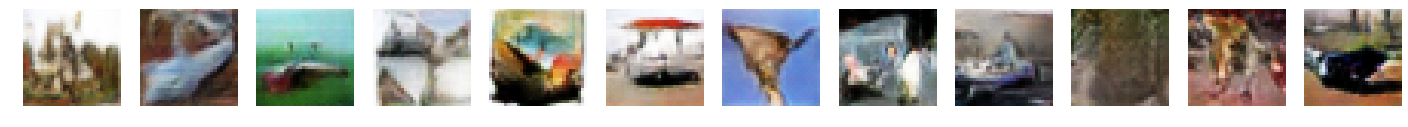

Epoch: 97/100 | Gen. Loss: 0.15582 | Disc. Loss: -1.19770 | Incep. Score: 6.19654


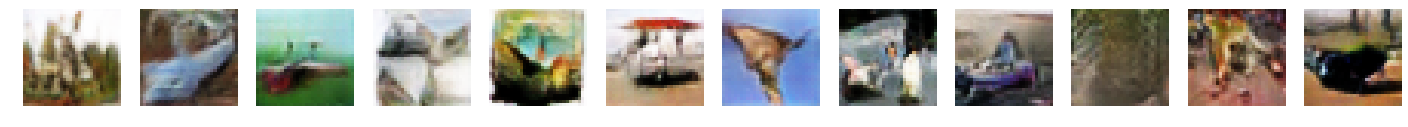

Epoch: 98/100 | Gen. Loss: 0.30727 | Disc. Loss: -1.18743 | Incep. Score: 6.21413


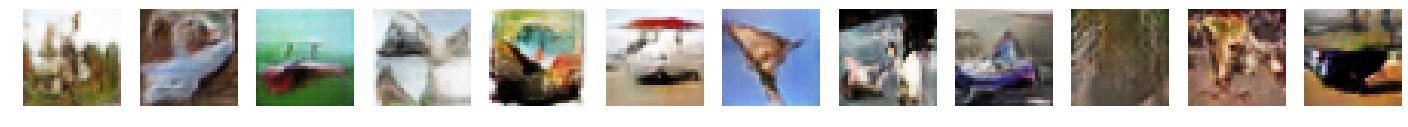

Epoch: 99/100 | Gen. Loss: 0.16274 | Disc. Loss: -1.20057 | Incep. Score: 6.23677


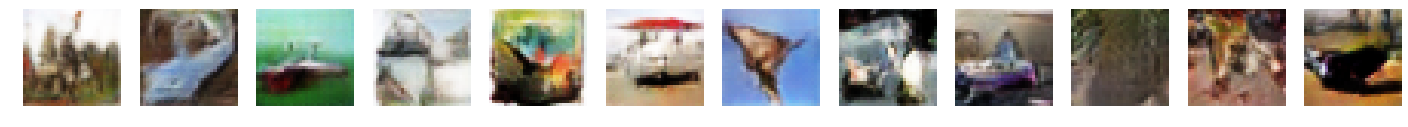

Epoch: 100/100 | Gen. Loss: 0.11666 | Disc. Loss: -1.19827 | Incep. Score: 6.10640


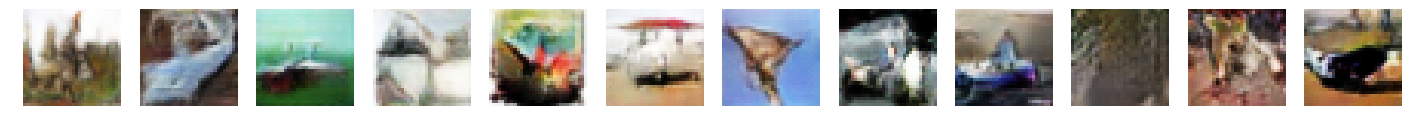

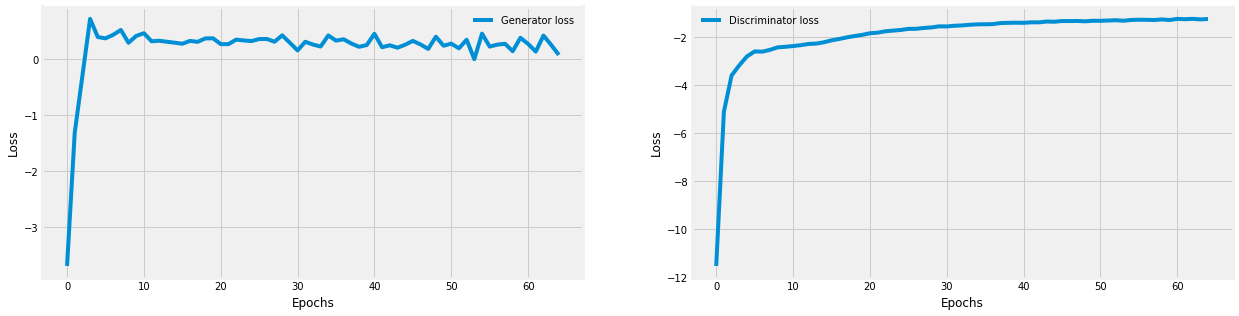

In [0]:
fig = plt.figure(figsize=(19, 5))

ax = fig.add_subplot(1, 2, 1)
ax.plot(lossesG, label='Generator loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(frameon=False)

ax = fig.add_subplot(1, 2, 2)
ax.plot(lossesD, label='Discriminator loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(frameon=False)

plt.show()

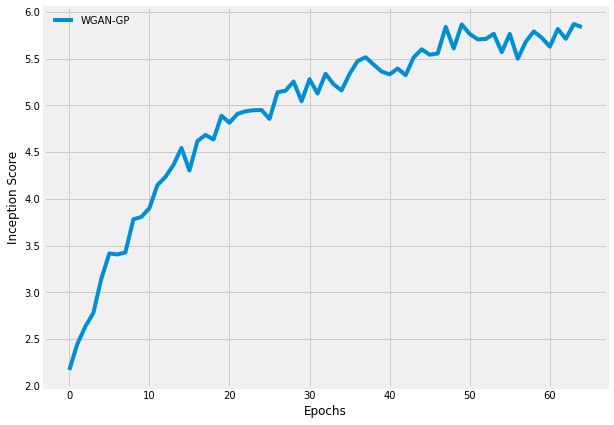

In [0]:
plt.figure(figsize=(9, 7))
plt.plot([mu for mu, std in scores], label='WGAN-GP')
plt.xlabel('Epochs')
plt.ylabel('Inception Score')
plt.legend(frameon=False)